In [1]:
import pandas as pd
import numpy as np
from scipy.special import softmax

def str2list_list(s):
    if s == '[]':
        return []
    s = s.replace('[[', '').replace(']]', '').replace("'", '').split('], [')
    return [[float(score) for score in ss.split(', ')] for ss in s]

def load_scores(filename): 
    # файлы должны лежать в папке scores, которая находится в той же директории, что и ноутбук
    df = pd.read_csv('scores/' + filename, sep='\t')
    if filename.startswith('maks'):
        df = df.drop(['sent1', 'sent2'], axis=1)
        df = df.rename({'pred':'score', 'sent1_orig':'sent1','sent2_orig':'sent2'}, axis=1)
    elif filename.startswith('Adis'):
        df.scores = df.scores.apply(str2list_list).apply(lambda l: [softmax(x) for x in l] if l!=[] else None)
        df['score'] = df.scores.apply(lambda l: l[0][1] if l is not None else np.nan)
    df['score1'] = df.score.apply(lambda x: x * 3 + 1)
    return df

In [2]:
filename = {'maks1': 'maks_base_1_scores.tsv', 'adis1': 'Adis_rusemshift_1_scores.tsv', 
            'maks2': 'maks_base_2_scores.tsv', 'adis2': 'Adis_rusemshift_2_scores.tsv'}
data = {name: load_scores(path) for name, path in filename.items()}
data.keys()

dict_keys(['maks1', 'adis1', 'maks2', 'adis2'])

In [3]:
# объединение скоров в один датафрейм
comb_data = {}
for n in (1,2):
    df = data[f'adis{n}'].copy()
    df = df.rename({'scores': 'scores_adis', 'score': 'score_adis', 'score1': 'score1_adis'}, axis=1)
    comb_data[n] = df.merge(data[f'maks{n}']).rename({'score': 'score_maks', 'score1': 'score1_maks'}, axis=1)

# Combination scores

In [4]:
# a0, a1 - скоры Адиса, m - скоры Максима
for i in (1,2):
    comb_data[i]['score_a0'] = comb_data[i].scores_adis.apply(lambda l: l[0][1] if l is not None else np.nan)
    comb_data[i]['score_a1'] = comb_data[i].scores_adis.apply(lambda l: l[1][1] if l is not None and len(l)>1 else np.nan)
    comb_data[i]['score_a0*a1'] = comb_data[i].apply(lambda r: r.score_a0*r.score_a1, axis=1)
    comb_data[i]['score_a0+a1'] = comb_data[i].apply(lambda r: r.score_a0+r.score_a1, axis=1)
    comb_data[i]['score_a0*a1*m'] = comb_data[i].apply(lambda r: r.score_a0*r.score_a1*r.score_maks, axis=1)
    comb_data[i]['score_a0+a1+m'] = comb_data[i].apply(lambda r: r.score_a0+r.score_a1+r.score_maks, axis=1)

In [5]:
df

word                                              sent1  \
0         ателье                                "Ателье -- налево".   
1         ателье  "Карат" привез в Россию "Куллинан" Бельгийская...   
2         ателье  "С жиру бесились, что ли Им бы помотаться по м...   
3         ателье  -- Посмотришь на нее, когда выходит из <b><i>а...   
4         ателье  ...Я еду в трамвае из <b><i>ателье</i></b> инд...   
...          ...                                                ...   
3628  эрмитажный  Читая цикл "Эрмитаж", даже отлично знающий это...   
3629  эрмитажный  Эта картина, когда-то считавшаяся гордостью <b...   
3630  эрмитажный  Это <b><i>эрмитажная</i></b> выставка, размеще...   
3631  эрмитажный  Я решил поговорить с самым умным человеком в н...   
3632  эрмитажный  Я уже хорошо ориентировался там, знал, что так...   

                                                  sent2    group  mean  \
0     (Написано в машине в ожидании Л. из <b><i>ател...  EARLIER   3.4   
1     Хотя Петр Петрович запретил Ираиде привозить в...    LATER   2.0   
2     Они и над универмагом так измывались, и над же...  EARLIER   4.0   
3     Для Easy Tiger это два партнерских <b><i>атель...    LATER   3.8   
4     Вокруг Зиновая Ивановича скоро организовался к...  COMPARE   3.8   
...                                                 ...      ...   ...   
3628  -- В следующем году в <b><i>Эрмитажном</i></b>...    LATER   3.0   
3629  <b><i>Эрмитажный</i></b> спектакль позволял за...  COMPARE   2.2   
3630  Но уже во вторую встречу, на <b><i>эрмитажном<...  COMPARE   3.4   
3631  В конце января 1904 года в <b><i>Эрмитажном</i...  COMPARE   3.2   
3632  В <b><i>эрмитажных</i></b> залах Анастасия был...  COMPARE   2.4   

      annotator1  annotator2  annotator3  annotator4  annotator5  \
0              3           4           4           3           3   
1              3           2           1           2           2   
2              4           4           4           4           4   
3              3           4           4           4           4   
4              4           4           4           4           3   
...          ...         ...         ...         ...         ...   
3628           4           4           3           3           1   
3629           4           1           4           1           1   
3630           3           4           4           4           2   
3631           3           4           4           4           1   
3632           3           4           2           1           2   

                                            scores_adis  score_adis  \
0                                                  None         NaN   
1     [[4.846072596898046e-05, 0.999951539274031], [...    0.999952   
2     [[3.432270946714505e-06, 0.9999965677290533], ...    0.999997   
3     [[0.0006261328875315785, 0.9993738671124686], ...    0.999374   
4     [[5.383391842959503e-05, 0.9999461660815699], ...    0.999946   
...                                                 ...         ...   
3628  [[0.0003453829202793565, 0.9996546170797208], ...    0.999655   
3629  [[0.00010656910875282378, 0.999893430891247], ...    0.999893   
3630  [[0.0011016924400162559, 0.9988983075599838], ...    0.998898   
3631  [[0.00021471157660311646, 0.9997852884233971],...    0.999785   
3632  [[1.0195196344230506e-05, 0.9999898048036555],...    0.999990   

      score1_adis  
0             NaN  
1        3.999855  
2        3.999990  
3        3.998122  
4        3.999838  
...           ...  
3628     3.998964  
3629     3.999680  
3630     3.996695  
3631     3.999356  
3632     3.999969  

[3633 rows x 13 columns]

In [6]:
df['find_c'] = df.apply(lambda r: r.sent1.find('ъ') != -1, axis=1)
for i, r in df[df.find_c == True][df.group != 'COMPARE'].iterrows():
    print(i, r.sent1)

10 В настоящее время начались съемки в <b><i>ателье.</i></b>
46 Перед ним как живой лежал у подъезда <b><i>ателье</i></b> человек с белокурой бородой.
103 "благотворительности" Занималась иною <b><i>благотворительностью:</i></b> благотворила профессорам, совершая периодические, обер-полицмейстерские объезды квартир, в результате которых роптали профессорши (мать моя -- плакала); профессорам же -- каждение: лучшие все Гогенштауфены!
193 На его жилой территории было обычным и своим, все: и пятиэтажные <b><i>блочные</i></b> дома с палисадниками, и лавочками у подъездов, и очереди у буфетов за пивом, сухим вином, шашлыками и черным ржаным хлебом.
199 Общее количество зданий 829 и состоит из двухъэтажных общежитий на 40 и 60 человек, трех- и четырехъэтажных корпусов 36-квартирных домов, 2 и 4 кварт. <b><i>блочных</i></b> одноэтажных, 2 кв. мансардных и т. д. Техническим Советом введен ряд корректив в утверждаемые проекты, часть забракована и часть передана на переработку "Югостали".
227 <b>

/home/maks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## 1-я часть датасета  
комбинация 3-х скоров улучшает результат (при вычислении корелл. для каждого примера) комбинации скоров Адиса на 1.3 пункта

In [7]:
n = 1
df = comb_data[n]
df = df[df.group == 'COMPARE']
s = {i for i in range(1, 6)}
for i in range(1, 6):
    df[f'mean_wo_{i}'] = df.apply(lambda r: np.mean([r[f'annotator{j}'] for j in s - {i}]), axis=1)
    
drop_cols = ['sent1','sent2','group','score_adis','score1_adis','score1_maks']# + [f'annotator{i}' for i in range(1,6)]
df_corr = df.drop(drop_cols, axis=1).corr(method='spearman')
for n_annot in range(1,6):
    corr = df_corr[f'annotator{n_annot}'][f'mean_wo_{n_annot}']
    print(f'annotator{n_annot} X mean_wo_{n_annot} = {corr:.4f}')
print()

methods = {'maks', 'a0', 'a1', 'a0*a1', 'a0+a1', 'a0*a1*m', 'a0+a1+m'}

corrs = []
for method in methods:
    corr = df_corr['mean'][f'score_{method}']
    corrs.append((method, corr))
    
corrs.sort(key=lambda x: x[1], reverse=True)
for method, corr in corrs:
    print(f'{method} X mean = {corr:.4f}')

/home/maks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


annotator1 X mean_wo_1 = 0.6332
annotator2 X mean_wo_2 = 0.6026
annotator3 X mean_wo_3 = 0.6264
annotator4 X mean_wo_4 = 0.6174
annotator5 X mean_wo_5 = 0.6120

a0*a1*m X mean = 0.5635
a0+a1+m X mean = 0.5575
a0+a1 X mean = 0.5502
a0*a1 X mean = 0.5490
a0 X mean = 0.5435
a1 X mean = 0.5384
maks X mean = 0.4964


In [8]:
from sklearn.metrics import accuracy_score

for n_annot in range(1,6):
    df_tmp = df[(df[f'mean_wo_{n_annot}'] < 2) | (df[f'mean_wo_{n_annot}'] > 3)]
    y_true = df_tmp[f'mean_wo_{n_annot}'].apply(lambda x: 'T' if x > 3 else 'F')
    y_pred = df_tmp[f'annotator{n_annot}'].apply(lambda x: 'T' if x >= 3 else 'F')
    acc = accuracy_score(y_true, y_pred)
    print(f'annotator{n_annot}: acc = {acc:.4f}')
print()
df_tmp = df[(df['mean'] < 2) | (df['mean'] > 3)]
df_tmp['tag_true'] = df_tmp['mean'].apply(lambda x: 'T' if x > 3 else 'F')
for method in methods:
    df_tmp[f'tag_{method}'] = df_tmp.apply(lambda r: 'T' if r[f'score_{method}'] > 0.5 else 'F', axis=1)
    acc = accuracy_score(df_tmp.tag_true, df_tmp[f'tag_{method}'])
    print('For',method,f'score, acc = {acc:.4f}', )

annotator1: acc = 0.8857
annotator2: acc = 0.8879
annotator3: acc = 0.8750
annotator4: acc = 0.8962
annotator5: acc = 0.8798

For a0 score, acc = 0.6938
For a0*a1*m score, acc = 0.5791
For a1 score, acc = 0.6891
For a0+a1 score, acc = 0.7175
For maks score, acc = 0.6825
For a0*a1 score, acc = 0.6664
For a0+a1+m score, acc = 0.7450


/home/maks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/maks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


#### Агрегация по словам

In [9]:
#df = df.dropna()
mask = (df.annotator1 != 0) & (df.annotator2 != 0) & (df.annotator3 != 0) & \
        (df.annotator4 != 0) & (df.annotator5 != 0)
df_word = df[mask].drop(drop_cols, axis=1).groupby('word').agg(lambda x: np.mean(x)).reset_index()
df_corr = df_word.corr(method='spearman')

for n_annot in range(1,6):
    corr = df_corr[f'annotator{n_annot}'][f'mean_wo_{n_annot}']
    print(f'annotator{n_annot} X mean_wo_{n_annot} = {corr:.4f}')
print()

methods = {'maks', 'a0', 'a1', 'a0*a1', 'a0+a1', 'a0*a1*m', 'a0+a1+m'}

corrs = []
for method in methods:
    corr = df_corr['mean'][f'score_{method}']
    corrs.append((method, corr))
    
corrs.sort(key=lambda x: x[1], reverse=True)
for method, corr in corrs:
    print(f'{method} X mean = {corr:.4f}')

annotator1 X mean_wo_1 = 0.9604
annotator2 X mean_wo_2 = 0.9469
annotator3 X mean_wo_3 = 0.9483
annotator4 X mean_wo_4 = 0.9239
annotator5 X mean_wo_5 = 0.9442

a0+a1+m X mean = 0.7423
a1 X mean = 0.7145
maks X mean = 0.7109
a0+a1 X mean = 0.7044
a0*a1 X mean = 0.6984
a0*a1*m X mean = 0.6952
a0 X mean = 0.6845


In [10]:
quant = 0.25
df_word_quant = df[['word']+[f'score_{x}' for x in methods]].dropna().groupby('word').agg(lambda x: np.quantile(x, quant)).reset_index()
df_word_quant = df_word_quant.merge(df.groupby('word').agg({'mean': lambda x: np.mean(x)}).reset_index())
df_corr = df_word_quant.corr(method='spearman')
corrs = []
for method in methods:
    corr = df_corr['mean'][f'score_{method}']
    corrs.append((method, corr))
    
corrs.sort(key=lambda x: x[1], reverse=True)
print('Quantile =', quant, end='\n\n')
for method, corr in corrs:
    print(f'{method} X mean = {corr:.4f}')

Quantile = 0.25

maks X mean = 0.7646
a1 X mean = 0.7580
a0*a1*m X mean = 0.7529
a0+a1+m X mean = 0.7510
a0+a1 X mean = 0.7366
a0*a1 X mean = 0.7322
a0 X mean = 0.7129


In [11]:
min_diff_method_and_true = 0.5
min_true_mean = 3.2
max_pred_score = 3.

max_pred_score = (max_pred_score - 1) / 3

df_word['diff_mean_maks'] = df_word.apply(lambda r: abs(r['mean'] - (r.score_maks*3+1)), axis=1)
df_word_error_analyze = df_word[df_word['mean']>min_true_mean][df_word.diff_mean_maks>min_diff_method_and_true] \
                               [df_word['score_maks'] < max_pred_score]
df_word = df_word.drop('diff_mean_maks', axis=1)
words = list(df_word_error_analyze.word)
#df_word_error_analyze

/home/maks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/maks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Count err examples with diff > 0.5,  min_true_mean = 3.2, max_pred_score = 3.0:
 192 (13.67%)


/home/maks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/maks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


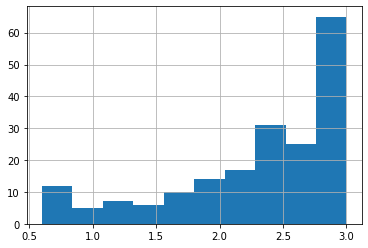

In [12]:
df_error_analyze = df.copy()
df_error_analyze['is_word'] = df.word.apply(lambda x: x in words)
df_error_analyze['diff_mean_maks'] = df_error_analyze.apply(lambda r: abs(r['mean']-(r.score_maks*3+1)), axis=1)
drop_methods = ['scores_adis','score_a1','score_a0*a1','score_a0+a1','score_a0*a1*m','score_a0+a1+m','score_adis',
                'mean_wo_1','mean_wo_2','mean_wo_3','mean_wo_4','mean_wo_5',
               'score1_adis','score1_maks','score_a0']
df_error_analyze = df_error_analyze[df_error_analyze.diff_mean_maks > min_diff_method_and_true] \
                                   [df_error_analyze.score_maks < max_pred_score] \
                                   [df_error_analyze.is_word==True].drop(['is_word']+drop_methods,axis=1)
cnt_err_examples = len(df_error_analyze)
print(f'Count err examples with diff > {min_diff_method_and_true},  min_true_mean = {min_true_mean},',
      f'max_pred_score = {max_pred_score*3+1}:\n', cnt_err_examples, f'({cnt_err_examples/len(df)*100:.2f}%)')
df_error_analyze.diff_mean_maks.hist()
#df_error_analyze

In [13]:
def target_at_begin_or_end(s):
    i = len(s) - 1
    close_tag = '</i></b>'
    len_tag = len(close_tag)
    while not s[i].isalpha() and s[i-len_tag+1:i+1] != close_tag:
        i -= 1
    return s.startswith('<b><i>') or s[i-len_tag+1:i+1] == close_tag
df_error_analyze['target_begin_or_end'] = df_error_analyze.apply(lambda r: target_at_begin_or_end(r.sent1) or 
                                                                           target_at_begin_or_end(r.sent2), axis=1)
print(df_error_analyze.target_begin_or_end.value_counts())
df_error_analyze1 = df_error_analyze[df_error_analyze.target_begin_or_end==False].drop('target_begin_or_end',axis=1)
df_error_analyze1

False    135
True      57
Name: target_begin_or_end, dtype: int64


word                                              sent1  \
15    богадельня  Долго крутились мы по узким улочкам, искали <b...   
17    богадельня  За церковью до моста с поворотом к <b><i>богад...   
28    богадельня  Надо признать, что содержание призреваемых был...   
48    богадельня  Тетя Паша добилась наконец желанной койки в <b...   
49    богадельня  То есть в <b><i>богадельню,</i></b> -- сказала...   
...          ...                                                ...   
4070    чиновник  Наказание это было страшно потому, что писарям...   
4079    чиновник  Они ответят улыбкой на многозначительную улыбк...   
4080    чиновник  Пожилой почтовый <b><i>чиновник</i></b> в очка...   
4087    чиновник  Соцалистическое государство, с его центральной...   
4092    чиновник  Тысячами шли рабочие, ремесленники, мужчины и ...   

                                                  sent2    group  mean  \
15    Моя <b><i>богадельня</i></b> сделалась вольным...  COMPARE   2.8   
17    В беднейшие монастыри велено уделять доходы бо...  COMPARE   3.8   
28    Но, отдавая в ведомство духовенства эту немало...  COMPARE   3.2   
48    -- Ступай вон, у меня не <b><i>богадельня!</i>...  COMPARE   3.4   
49    Многое делалось и для поддержания наружного по...  COMPARE   4.0   
...                                                 ...      ...   ...   
4070  Эти внутренние таможенные пошлины, ликин, взим...  COMPARE   3.6   
4079  В шести верстах от Дуэ на открытом месте уже с...  COMPARE   3.6   
4080  "Что же это, сон или нет, -- думал он, -- наст...  COMPARE   3.2   
4087  Между тем под вечер прислан был к послу <b><i>...  COMPARE   3.8   
4092  Орловский, <b><i>чиновник</i></b> Варченко и п...  COMPARE   3.0   

      annotator1  annotator2  annotator3  annotator4  annotator5  score_maks  \
15             2           1           3           4           4    0.064178   
17             3           4           4           4           4    0.000239   
28             4           1           4           3           4    0.043876   
48             3           4           3           4           3    0.092235   
49             4           4           4           4           4    0.000175   
...          ...         ...         ...         ...         ...         ...   
4070           2           4           4           4           4    0.000154   
4079           4           4           4           2           4    0.030300   
4080           4           3           3           4           2    0.000038   
4087           4           4           4           3           4    0.000045   
4092           4           3           2           2           4    0.000040   

      diff_mean_maks  
15          1.607467  
17          2.799283  
28          2.068371  
48          2.123295  
49          2.999475  
...              ...  
4070        2.599537  
4079        2.509100  
4080        2.199886  
4087        2.799864  
4092        1.999879  

[135 rows x 12 columns]

In [14]:
for i, (idx, r) in enumerate(df_error_analyze1.sample(30, random_state=1).iterrows(), start=1):
    print(i,') ', r.word, ', mean = ',r['mean'], f', pred_score = {r.score_maks*3+1:.4f}', ', index = ', idx, sep='')
    print(r.sent1)
    print('=')
    print(r.sent2)
    print()

1) бюрократ, mean = 3.8, pred_score = 1.0002, index = 1403
Народ отвергает аппаратный деготь, который <b><i>бюрократы</i></b> пытаются залить вместо горючего в двигатели перестройки.
=
Мысль остепенялась, да и сам <b><i>бюрократ</i></b> смотрел осанистее, умнее.

2) археолог, mean = 4.0, pred_score = 1.0117, index = 1334
Известный индийский историк и <b><i>археолог</i></b> С. Дикшит отмечает, что "открытие эффективного метода плавки железа, намного опередившее его распространение, принадлежит племенам Армянского нагорья".
=
Знавшие хорошо Озерова: знаменитый баснописец И.А.Крылов, Н.И.Гнедич и <b><i>археолог</i></b> Ермолаев сказывали мне, что Озеров был добрый и благородный человек, но имел несчастный характер: был подозрителен, недоверчив, щекотлив, раздражителен в высшей степени, притом мнителен и самолюбив до последней крайности.

3) правитель, mean = 3.8, pred_score = 1.0001, index = 2978
И массы озлоблялись, и движение заострялось против официальных <b><i>правителей,</i></b> кото

In [15]:
word = 'прозвище'
df_one_word = df[df.word==word].drop(drop_methods, axis=1)
df_one_word['diff'] = df_one_word.apply(lambda r: abs(r['mean'] - (r.score_maks*3 + 1)), axis=1)
print(f'Доля неправильных примеров для слова "{word}" =', len(df_one_word[df_one_word['diff'] > 0.5]) / len(df_one_word))

Доля неправильных примеров для слова "прозвище" = 0.75


/home/maks/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


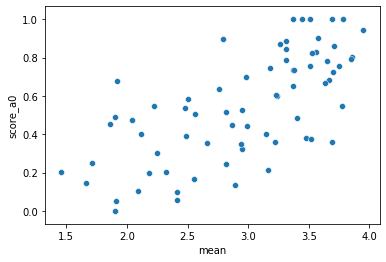

In [16]:
import seaborn as sns
ax = sns.scatterplot(df_word['mean'], df_word['score_a0'])
#ax.set_xscale('log')

## 2-я часть датасета  
комбинация 3-х скоров улучшает результат (при вычислении корелл. для каждого примера) комбинации скоров Адиса на 1.5 пункта

In [17]:
n = 2
df = comb_data[n]
df = df[df.group == 'COMPARE']
s = {i for i in range(1, 6)}
for i in range(1, 6):
    df[f'mean_wo_{i}'] = df.apply(lambda r: np.mean([r[f'annotator{j}'] for j in s - {i}]), axis=1)
    
drop_cols = ['sent1','sent2','group','score_adis','score1_adis','score1_maks']# + [f'annotator{i}' for i in range(1,6)]
df_corr = df.drop(drop_cols, axis=1).corr(method='spearman')
for n_annot in range(1,6):
    corr = df_corr[f'annotator{n_annot}'][f'mean_wo_{n_annot}']
    print(f'annotator{n_annot} X mean_wo_{n_annot} = {corr:.4f}')
print()

methods = {'maks', 'a0', 'a1', 'a0*a1', 'a0+a1', 'a0*a1*m', 'a0+a1+m'}

corrs = []
for method in methods:
    corr = df_corr['mean'][f'score_{method}']
    corrs.append((method, corr))
    
corrs.sort(key=lambda x: x[1], reverse=True)
for method, corr in corrs:
    print(f'{method} X mean = {corr:.4f}')

/home/maks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


annotator1 X mean_wo_1 = 0.6711
annotator2 X mean_wo_2 = 0.6132
annotator3 X mean_wo_3 = 0.6207
annotator4 X mean_wo_4 = 0.6679
annotator5 X mean_wo_5 = 0.6632

a0*a1*m X mean = 0.5943
a0+a1+m X mean = 0.5908
a0*a1 X mean = 0.5808
a0+a1 X mean = 0.5808
a1 X mean = 0.5719
a0 X mean = 0.5665
maks X mean = 0.5287


In [18]:
from sklearn.metrics import accuracy_score

for n_annot in range(1,6):
    df_tmp = df[(df[f'mean_wo_{n_annot}'] < 2) | (df[f'mean_wo_{n_annot}'] > 3)]
    y_true = df_tmp[f'mean_wo_{n_annot}'].apply(lambda x: 'T' if x > 3 else 'F')
    y_pred = df_tmp[f'annotator{n_annot}'].apply(lambda x: 'T' if x >= 3 else 'F')
    acc = accuracy_score(y_true, y_pred)
    print(f'annotator{n_annot}: acc = {acc:.4f}')
print()
df_tmp = df[(df['mean'] < 2) | (df['mean'] > 3)]
df_tmp['tag_true'] = df_tmp['mean'].apply(lambda x: 'T' if x > 3 else 'F')
for method in methods:
    df_tmp[f'tag_{method}'] = df_tmp.apply(lambda r: 'T' if r[f'score_{method}'] > 0.5 else 'F', axis=1)
    acc = accuracy_score(df_tmp.tag_true, df_tmp[f'tag_{method}'])
    print('For',method,f'score, acc = {acc:.4f}', )

annotator1: acc = 0.8945
annotator2: acc = 0.8464
annotator3: acc = 0.8637
annotator4: acc = 0.8833
annotator5: acc = 0.8840

For a0 score, acc = 0.7684
For a0*a1*m score, acc = 0.6630
For a1 score, acc = 0.7574
For a0+a1 score, acc = 0.7827
For maks score, acc = 0.7256
For a0*a1 score, acc = 0.7398
For a0+a1+m score, acc = 0.7991


/home/maks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/maks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


#### Агрегация по словам

In [19]:
mask = (df.annotator1 != 0) & (df.annotator2 != 0) & (df.annotator3 != 0) & \
        (df.annotator4 != 0) & (df.annotator5 != 0)
df_word = df[mask].drop(drop_cols, axis=1).groupby('word').agg(lambda x: np.mean(x)).reset_index()
df_corr = df_word.corr(method='spearman')

for n_annot in range(1,6):
    corr = df_corr[f'annotator{n_annot}'][f'mean_wo_{n_annot}']
    print(f'annotator{n_annot} X mean_wo_{n_annot} = {corr:.4f}')
print()

methods = {'maks', 'a0', 'a1', 'a0*a1', 'a0+a1', 'a0*a1*m', 'a0+a1+m'}

corrs = []
for method in methods:
    corr = df_corr['mean'][f'score_{method}']
    corrs.append((method, corr))
    
corrs.sort(key=lambda x: x[1], reverse=True)
for method, corr in corrs:
    print(f'{method} X mean = {corr:.4f}')

annotator1 X mean_wo_1 = 0.9526
annotator2 X mean_wo_2 = 0.9484
annotator3 X mean_wo_3 = 0.9147
annotator4 X mean_wo_4 = 0.9446
annotator5 X mean_wo_5 = 0.9495

a0+a1+m X mean = 0.7518
a0+a1 X mean = 0.7361
a0 X mean = 0.7329
a1 X mean = 0.7257
a0*a1 X mean = 0.7120
a0*a1*m X mean = 0.6842
maks X mean = 0.6820


In [20]:
quant = 0.25
df_word_quant = df[['word']+[f'score_{x}' for x in methods]].dropna().groupby('word').agg(lambda x: np.quantile(x, quant)).reset_index()
df_word_quant = df_word_quant.merge(df.groupby('word').agg({'mean': lambda x: np.mean(x)}).reset_index())
df_corr = df_word_quant.corr(method='spearman')
corrs = []
for method in methods:
    corr = df_corr['mean'][f'score_{method}']
    corrs.append((method, corr))
    
corrs.sort(key=lambda x: x[1], reverse=True)
print('Quantile =', quant, end='\n\n')
for method, corr in corrs:
    print(f'{method} X mean = {corr:.4f}')

Quantile = 0.25

a0+a1+m X mean = 0.7446
a0+a1 X mean = 0.7261
a0*a1*m X mean = 0.7256
a1 X mean = 0.7131
a0*a1 X mean = 0.7114
a0 X mean = 0.7049
maks X mean = 0.6038


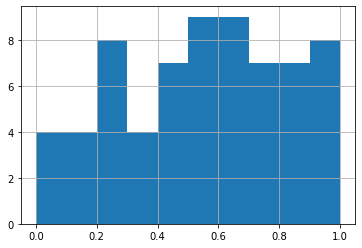

In [21]:
df_word.score_a0.hist()

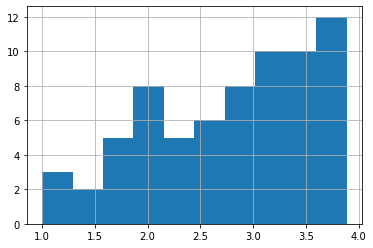

In [22]:
df_word['mean'].hist()

/home/maks/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


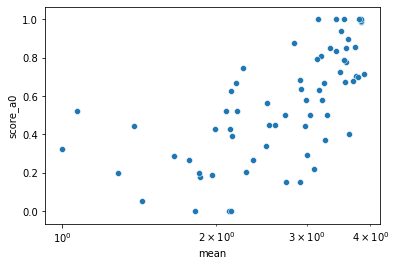

In [23]:
import seaborn as sns
ax = sns.scatterplot(df_word['mean'], df_word['score_a0'])
ax.set_xscale('log')